In [1]:
import json
import bz2
import regex
from tqdm import tqdm
from scipy import sparse
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:07, 2989.12it/s]


In [3]:
responses[0]

{'city': 'г. Москва',
 'rating_not_checked': False,
 'title': 'Жалоба',
 'num_comments': 0,
 'bank_license': 'лицензия № 2562',
 'author': 'uhnov1',
 'bank_name': 'Бинбанк',
 'datetime': '2015-06-08 12:50:54',
 'text': 'Добрый день! Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности.  Начиная с марта 2015 года начали приходить бесконечные письма из ООО "Примо коллект"на мой адрес: город Москва, Уваровский переулок, дом 10, квартира 111, с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича, который уклоняется от уплаты взятых им кредитов: договор № 81014 от 20.10.2013 года и договор № 2464946 от 09.10.2014 года. Со всей ответственностью\xa0 хочу Вас заверить, что вышеуказанный гражданин, которого Вы разыскиваете, мне не знаком и никогда в моем адресе не был зарегистрирован. Каким образом Вы не удо

## Формируем данные

In [4]:
data = pd.DataFrame.from_dict(responses)
data = data.dropna()

In [5]:
data.head()

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title
14,yura1189,лицензия № 2673,Тинькофф Банк,г. Москва,2015-06-05 13:52:40,0,2.0,False,"Также как и многие давний клиент банка, был до...",В Шоке
19,agelun,лицензия № 1481,Сбербанк России,г. Москва,2015-06-05 15:00:54,2,1.0,False,Открыт вклад и счет в USD. Плюс к этому есть з...,Некомпетентность сотрудников банка
33,Joker888,лицензия № 1481,Сбербанк России,г. Ростов-на-Дону,2015-06-05 21:35:40,1,1.0,False,Доброго времени! Вчера мне поступило смс-уведо...,Навязывание страховки
76,qwarta45,лицензия № 3006,АктивКапитал Банк,г. Санкт-Петербург,2015-06-06 23:42:39,0,1.0,False,"05.06.2015г. около 15 часов, пришел в указанны...",Нарушение договора банковского вклада
85,721,лицензия № 1481,Сбербанк России,г. Москва,2015-06-04 13:27:04,4,1.0,False,Для оплаты коммунальных платежей пользуюсь пла...,"Невозможно оплатить отчисления на капремонт ""Т..."


## Количесво отзывов по банкам и городам

In [15]:
count_by_city = data.groupby(['bank_name','city'])

In [16]:
count_by_city.count()['text'].head(50)

bank_name  city                                
2Т Банк    г. Moscow                                 1
           г. Mscow                                  1
           г. Белгород (Москва)                      1
           г. Бугульма                               1
           г. Волгодонск                             2
           г. Воронеж                                1
           г. Дмитров                                1
           г. Екатеринбург                           3
           г. Истра                                  1
           г. Казань                                 1
           г. Калининград                            2
           г. Красноармейск                          1
           г. Краснодар                              5
           г. Красноярск                             1
           г. Липецк                                 1
           г. Луховицы Московской обл.               1
           г. Магнитогорск                           1
           г. Мар

In [17]:
len_data = data.text.apply(len)
len_data.describe()

count    74710.000000
mean      1776.943194
std       1409.132727
min         66.000000
25%        896.000000
50%       1397.000000
75%       2193.000000
max      32082.000000
Name: text, dtype: float64

## Длины отзывов в символах

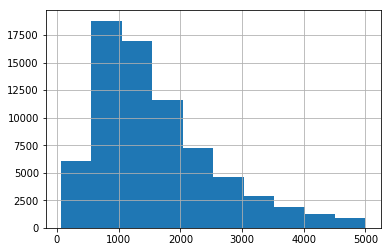

In [18]:
length = len_data[len_data < 5000].hist()

In [41]:
import re
regex = re.compile("[А-Яа-яЁё]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""


data=data.assign(words=data.text.str.lower())
data.words = data.words.apply(words_only)

In [42]:
len_in_words = data.words.str.split().apply(len)
len_in_words.describe()

count    74710.000000
mean       263.742859
std        210.762569
min         10.000000
25%        131.000000
50%        207.000000
75%        327.000000
max       5001.000000
Name: words, dtype: float64

## Длины отзывов в словах

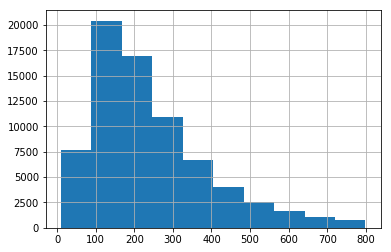

In [21]:
len_in_words[len_in_words<800].hist()

In [22]:
from collections import Counter
from tqdm import tqdm_notebook as tqdm


In [23]:
def count_and_plot(column):
    cnt = Counter()
    n_types = []
    n_tokens = []
    tokens = []
    for index, row in tqdm(data.iterrows(), total = len(data)):
        tokens = row[column].split()
        cnt.update(tokens)
        n_types.append(len(cnt))
        n_tokens.append(np.sum(list(cnt.values())))
    for i in cnt.most_common(10):
        print(i)
    freqs = list(cnt.values())
    freqs = sorted(freqs, reverse = True)

    fig, (ax1,ax2) = plt.subplots(ncols=2)
    ax1.plot(freqs[:300], range(300))
    ax2.plot(n_tokens, n_types)
    plt.show()


('в', 748641)
('и', 594700)
('не', 471686)
('на', 394656)
('что', 365487)
('я', 323819)
('с', 251000)
('по', 205269)
('мне', 185064)
('банка', 152600)


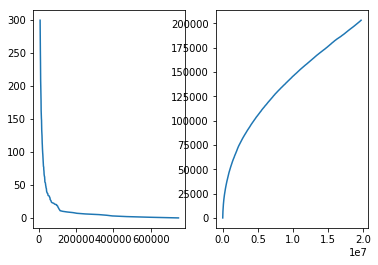

Wall time: 10min 8s


In [24]:
%%time
count_and_plot('words')

## Удалим стоп-слова

In [43]:
from nltk.corpus import stopwords
from pymystem3 import Mystem

In [44]:
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д']
def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

    
m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return [l for l in m.lemmatize(text) if l.isalpha()]
    except:
        return []

In [45]:
%%time
data['wo_stop'] = data.words.apply(lambda x: remove_stopwords(x))

Wall time: 22.8 s



('банка', 152600)
('банк', 114850)
('деньги', 72829)
('карту', 61763)
('карты', 57407)
('отделение', 42904)
('день', 42289)
('заявление', 41102)
('банке', 39943)
('кредит', 39937)


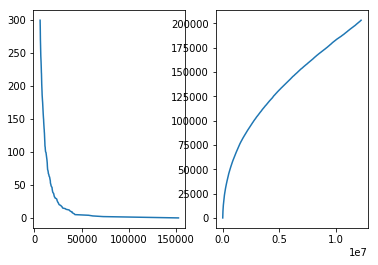

In [28]:
count_and_plot('wo_stop')

### Для лемматизации пришлось разобраться с мультипроцессингом. 
### На windows это не просто. Функцию лемматизации пришлось положить в отдельный модуль, тогда всё заработало. Туда же включил посчет сущесвительных

In [94]:
import multiprocessing as mp
import lemm2
import importlib
importlib.reload(lemm2)

<module 'lemm2' from 'C:\\Users\\Michael\\Documents\\netology\\text2\\lemm2.py'>

In [31]:
from pymorphy2 import MorphAnalyzer
pm2 = MorphAnalyzer()

In [95]:
%%time
num_cpus = mp.cpu_count()
NOUN_count = 0
with mp.Pool(processes=num_cpus) as pool:
    lemmas = pool.map(lemm2.lemmatize2,data.wo_stop)

Wall time: 6min 13s


In [96]:
l,c = zip(*lemmas)
data['lemma'] = l
print ('К-во существительных: ' + str(sum(c)))

К-во существительных: 5920052


In [35]:
def count_and_plot_lemma(column):
    cnt = Counter()
    n_types = []
    n_tokens = []
    tokens = []
    for index, row in tqdm(data.iterrows(), total = len(data)):
        tokens = row[column]
        cnt.update(tokens)
        n_types.append(len(cnt))
        n_tokens.append(np.sum(list(cnt.values())))
    for i in cnt.most_common(10):
        print(i)
    freqs = list(cnt.values())
    freqs = sorted(freqs, reverse = True)

    fig, (ax1,ax2) = plt.subplots(ncols=2)
    ax1.plot(freqs[:300], range(300))
    ax2.plot(n_tokens, n_types)
    plt.show()


('банка', 219969)
('карта', 189965)
('банк', 143265)
('деньга', 99900)
('день', 97449)
('отделение', 92701)
('год', 91899)
('мой', 87768)
('который', 83218)
('счёт', 79936)


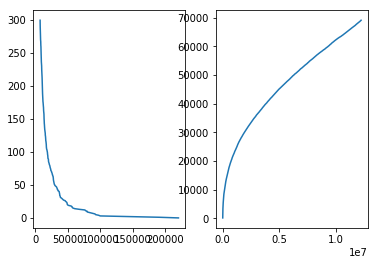

In [36]:
count_and_plot_lemma('lemma')

## Количество заданных слов

In [37]:
word_count = Counter()
for index, row in data.iterrows():
        word_count.update(row['lemma']) 

In [38]:
print('Клиент - ',word_count['клиент'],'Сотрудник - ',word_count['сотрудник'])

Клиент -  76436 Сотрудник -  79824


In [39]:
print('мошенничество - ',word_count['мошенничество'],'доверие - ',word_count['доверие'])

мошенничество -  1193 доверие -  1103


## Делим данные на положительные и отрицательные по рейтингу

In [97]:
data_plus = data[data.rating_grade == 5]
data_plus.head()

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title,words,wo_stop,lemma
98,apka45,лицензия № 1073,Русславбанк,г. Санкт-Петербург,2015-06-03 17:40:38,0,5.0,False,Досрочно закрывали вклады перед отпуском. Жена...,"Хорошо, когда проблемы решаются",досрочно закрывали вклады перед отпуском жена ...,досрочно закрывали вклады отпуском жена заказы...,"[досрочно, закрывать, вклад, отпуск, жена, зак..."
122,20157673,лицензия № 226,РосинтерБанк,г. Нижний Новгород,2015-06-04 09:38:18,3,5.0,False,"Хотел открыть вклад ""Доходный+"" под 19% год , ...",Изменяют проценты по уже открытому договору вк...,хотел открыть вклад доходный под год проценты ...,хотел открыть вклад доходный год проценты начи...,"[хотеть, открыть, вклад, доходный, год, процен..."
157,ospar,лицензия № 1623,ВТБ 24,г. Москва,2015-06-04 22:58:38,0,5.0,False,"Вчера, 3 июня, просидев в очереди более 3-х ча...","Отделение Марксистская, дом 5: спасибо за помощь!",вчера июня просидев в очереди более х часов на...,вчера июня просидев очереди х часов получение ...,"[вчера, июнь, просидеть, очередь, х, часы, пол..."
259,ser-gyr,лицензия № 3206,Соверен Банк,г. Москва,2015-06-02 18:23:41,0,5.0,False,Сегодня открывал вклад в этом банке. Очередь б...,Хорошее обслуживание,сегодня открывал вклад в этом банке очередь бы...,сегодня открывал вклад банке очередь одного кл...,"[сегодня, открывать, вклад, банка, очередь, од..."
266,SkaIa,лицензия № 3354,Ренессанс Кредит,г. Москва,2015-06-03 02:03:28,1,5.0,False,Моя история получения кредита в Ренессанс Кред...,Моя история получения кредита в Ренессанс Кред...,моя история получения кредита в ренессанс кред...,история получения кредита ренессанс кредит бан...,"[история, получение, кредит, ренессанс, кредит..."


In [98]:
data_minus = data[data.rating_grade == 1]
data_minus.head()

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title,words,wo_stop,lemma
19,agelun,лицензия № 1481,Сбербанк России,г. Москва,2015-06-05 15:00:54,2,1.0,False,Открыт вклад и счет в USD. Плюс к этому есть з...,Некомпетентность сотрудников банка,открыт вклад и счет в плюс к этому есть зарпла...,открыт вклад счет плюс этому зарплатная карта ...,"[открытый, вклад, счёт, плюс, это, зарплатный,..."
33,Joker888,лицензия № 1481,Сбербанк России,г. Ростов-на-Дону,2015-06-05 21:35:40,1,1.0,False,Доброго времени! Вчера мне поступило смс-уведо...,Навязывание страховки,доброго времени вчера мне поступило смс уведом...,доброго времени вчера поступило смс уведомлени...,"[добрый, время, вчера, поступить, смс, уведомл..."
76,qwarta45,лицензия № 3006,АктивКапитал Банк,г. Санкт-Петербург,2015-06-06 23:42:39,0,1.0,False,"05.06.2015г. около 15 часов, пришел в указанны...",Нарушение договора банковского вклада,г около часов пришел в указанный офис с намере...,г около часов пришел указанный офис намерением...,"[год, около, часы, прийти, указанный, офис, на..."
85,721,лицензия № 1481,Сбербанк России,г. Москва,2015-06-04 13:27:04,4,1.0,False,Для оплаты коммунальных платежей пользуюсь пла...,"Невозможно оплатить отчисления на капремонт ""Т...",для оплаты коммунальных платежей пользуюсь пла...,оплаты коммунальных платежей пользуюсь пластик...,"[оплата, коммунальный, платёж, пользоваться, п..."
94,usmanovaket,лицензия № 1481,Сбербанк России,г. Чапаевск,2015-06-03 16:00:12,16,1.0,False,В апреле этого года пришла в отделение сбербан...,Некомпетентность сотрудника Сбербанка при пров...,в апреле этого года пришла в отделение сбербан...,апреле года пришла отделение сбербанка г чапае...,"[апрель, год, пришлый, отделение, сбербанк, го..."


In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer

## Выделяем ключевые слова для обоих наборов

In [67]:
%%time
tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df = 0)
tfidf_matrix =  tfidf.fit_transform(data_plus.wo_stop)
feature_names = tfidf.get_feature_names() 

Wall time: 8.26 s


In [68]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

In [69]:
sorted_items=sort_coo(tfidf_matrix.tocoo())

In [72]:
for index, score in sorted_items[:50]:
    print(feature_names[index],score)

пд 0.549289206323554
маштакова анна 0.474124233964895
маштакова 0.474124233964895
солнечногорск 0.44758364556734703
марюс 0.421827136795517
миль 0.4217735613645644
гарантий 0.414041902849711
вэб 0.41386450403610664
впб 0.4090593071872085
джиргал 0.4012763528301146
першинг 0.396036486636669
регулярная 0.38966035319243014
щукинский 0.3895647644973364
ххххх 0.38780531965749593
ке банка 0.3859395766257242
екатерина андреевна 0.3858330717663183
райф банк 0.3858111145693794
тумбочки 0.3804058336599061
сбб 0.37963270042896585
овч 0.37835121519504056
инна 0.37360049124986283
кки 0.3721768601952811
райф 0.3688056553738357
бла 0.3685633345501303
илаха 0.3668482591126928
семинар 0.36593593389835
гульназ 0.3654919959601394
отп 0.36157187558738596
кеб 0.35747994573381825
симоновой 0.353047145198586
гпб 0.3461668411798418
билайн 0.34585438141651514
арижк 0.34571859921156073
настроили 0.345330554004782
жулебино 0.34424198168732445
ля 0.34406562393410756
аккредитив 0.34277217374067676
азс 0.3423223285

In [73]:
tfidf_matrix =  tfidf.fit_transform(data_minus.wo_stop)
feature_names = tfidf.get_feature_names() 
sorted_items=sort_coo(tfidf_matrix.tocoo())
for index, score in sorted_items[:50]:
    print(feature_names[index],score)

почему казалось 0.7753530368813523
юб 0.7015353193754122
ргс 0.6306726251424118
гость 0.6129019726308584
мб 0.6099136008021058
дир 0.6071980176458456
тыханская юлия 0.6027425257247744
тыханская 0.6027425257247744
барклайс 0.5947596247211124
равно равно 0.5891976827261219
птс 0.573360276816945
бпф 0.5585217821823558
юкб 0.550544412755565
клиент 0.5446584448718924
оао отп 0.5446152858002106
старик 0.5434549594352502
сек 0.536322457696814
кбк 0.5358575396765666
ап 0.5314568473840887
псб 0.5307019149454084
бк 0.5304156361906969
оао отп 0.5300208759691234
чдп 0.5270316364986533
гиб 0.5199565859630937
машинцева 0.5191970206189401
яд 0.5156106992272748
банка рублев 0.5143536442276564
позвонил готова 0.5067980777525412
сергей александрович 0.5064991792084637
мб 0.5050499090133643
нпф 0.5003571904081124
плата овердрафт 0.4962421578586312
хх 0.4955752159164768
визит денег 0.4909164795935181
строительство 0.4906642989238617
рублей платежное 0.48802621630380016
хх 0.48784565589385004
главный жалоб

# Часть 2

In [208]:
from gensim import corpora, models
import gensim

In [211]:
dictionary = corpora.Dictionary(data.lemma)
corpus = [dictionary.doc2bow(text) for text in data.lemma]

In [214]:
%%time 
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word = dictionary, passes=20)

Wall time: 14min 40s


In [255]:
dictionary.token2id['сбербанк']

480

In [257]:
dictionary.dfs[480]

13574

In [242]:
ldamodel.print_topics(num_topics=5, num_words=5)

[(0,
  '0.060*"карта" + 0.018*"банка" + 0.018*"банк" + 0.012*"счёт" + 0.009*"интернет"'),
 (1,
  '0.024*"деньга" + 0.019*"день" + 0.017*"заявление" + 0.017*"отделение" + 0.016*"карта"'),
 (2,
  '0.010*"отделение" + 0.009*"деньга" + 0.009*"работать" + 0.009*"сказать" + 0.008*"очередь"'),
 (3,
  '0.033*"кредит" + 0.024*"банка" + 0.017*"банк" + 0.015*"год" + 0.014*"сумма"'),
 (4,
  '0.030*"банка" + 0.020*"вклад" + 0.015*"банк" + 0.012*"клиент" + 0.010*"документ"')]

In [216]:
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

C:\ProgramData\Anaconda3\lib\site-packages\past\types\oldstr.py:33: DeprecationWarning: invalid escape sequence \d
  """
C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


# Часть 3

In [99]:
data_minus.shape, data_plus.shape

((39855, 13), (10511, 13))

In [100]:
data_plus_minus = data_minus[:10000].copy()

In [101]:
data_plus_minus = data_plus_minus.append(data_plus[:10000], ignore_index=True, sort=False)

In [102]:
data_plus_minus.shape

(20000, 13)

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [155]:
X = data_plus_minus['wo_stop']
Y = data_plus_minus['rating_grade']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2)

In [181]:
pip = Pipeline([ 
    ('vect', CountVectorizer(analyzer='word', ngram_range=(1,2))), 
    ('tfidf', TfidfTransformer()), 
    #('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier(n_estimators=100,n_jobs=-1))
])

In [182]:
%%time
pip.fit(X_train, Y_train)

Wall time: 51.3 s


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip..._jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [183]:
pred = pip.predict(X_test)

In [184]:
from sklearn.metrics import *

In [185]:
print("F1-measure: {0:6.2f}".format(f1_score(Y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(Y_test, pred)))

F1-measure:   0.94
Accuracy:   0.94


In [187]:
from sklearn.decomposition import LatentDirichletAllocation

In [200]:
pip = Pipeline([ 
    ('vect', CountVectorizer(analyzer='word', ngram_range=(1,2),max_features=1000)), 
    ('lda',  LatentDirichletAllocation(n_components=10, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0, n_jobs=-1)), 
    ('clf', RandomForestClassifier(n_estimators=10,n_jobs=-1))
])

In [201]:
%%time
pip.fit(X_train, Y_train)

Wall time: 49.1 s


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip..._jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [202]:
pred = pip.predict(X_test)
print("F1-measure: {0:6.2f}".format(f1_score(Y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(Y_test, pred)))

F1-measure:   0.89
Accuracy:   0.89


In [191]:
from sklearn.linear_model import LogisticRegression

In [205]:
pip = Pipeline([ 
    ('vect', CountVectorizer(analyzer='word', ngram_range=(1,2), max_df=0.95, min_df=2, max_features=1000)), 
    ('lda',  LatentDirichletAllocation(max_iter=10,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0, n_jobs=7)), 
    ('clf', LogisticRegression(C=10.0,n_jobs=7))
])

In [206]:
%%time
pip.fit(X_train, Y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 7.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Wall time: 1min 18s


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.95, max_features=1000, min_df=2,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        stri...penalty='l2', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False))])

In [207]:
pred = pip.predict(X_test)
print("F1-measure: {0:6.2f}".format(f1_score(Y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(Y_test, pred)))

F1-measure:   0.88
Accuracy:   0.88
